## PyRidy Example Notebook
The intent of this Jupyter Notebook to demonstrate and explain some of the capabilities of the PyRidy Library.

<div class="alert alert-block alert-info">
<b>Info:</b> PyRidy and the documentation are still in an early development phase. Therefore, features might change and the documentation is not yet complete
</div>

If pyridy is not installed in your environment, you can install it via:
```bash
    pip install pyridy
```
If pyridy is already installed, check whether you use the most recent version.
```shell
    pip install pyridy --upgrade
```

***

Documentation and API reference can be found here: <https://pyridy.readthedocs.io/en/latest/>

In [19]:
%load_ext autoreload
%autoreload 2

# Imports
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import signal

import pyridy

from pyridy.processing import ComfortProcessor
from pyridy.utils import AccelerationSeries, LinearAccelerationSeries, NTPDatetimeSeries, GyroSeries, GPSSeries, MagnetometerSeries # Every data series that should be used should be imported here
from RWTHColors import ColorManager

"""
The following TimeSeries classes currently exist:

    AccelerationSeries
    AccelerationUncalibratedSeries
    LinearAccelerationSeries
    MagnetometerSeries
    MagnetometerUncalibratedSeries
    NMEAMessageSeries
    GNSSClockMeasurementSeries
    GNSSMeasurementSeries
    OrientationSeries
    GyroSeries
    GyroUncalibratedSeries
    RotationSeries
    GPSSeries
    PressureSeries
    TemperatureSeries
    HumiditySeries
    LightSeries
    WzSeries
    SubjectiveComfortSeries
    
Whether these measurement were recorded, depends on the settings in the Ridy App and the device's capabilities.
"""

# logging.getLogger('pyridy').setLevel(logging.DEBUG)  # Uncomment this to see more information when pyridy functions are called

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading measurement files
Within the folder two measurements files can be found that are going to be imported. The argument download_osm_region tries to download additional OSM which includes
railway track data, railway lines, position of level crossings and switches. Sometimes the Overpass API which is used to access the data can be overloaded leading to an error.

In [15]:
# Loading multiple files by creating a measurement campaign
path = "../ridy_data"
#path = r"D://10_Daten/Ridy/Neu"

# campaign = pyridy.Campaign(folder=path, sync_method="ntp_time", download_osm_data=True, railway_types=["rail"], osm_recurse_type="<")

# Load only some timeseries
campaign = pyridy.Campaign(folder=path, sync_method="ntp_time", download_osm_data=True, railway_types=["rail"], osm_recurse_type=">")

File Import:   0%|          | 0/2 [00:00<?, ?it/s]

[WinError 10061] No connection could be made because the target machine actively refused it
[WinError 10061] No connection could be made because the target machine actively refused it


Bounding Boxes:   0%|          | 0/1 [00:00<?, ?it/s]

Railway Types:   0%|          | 0/1 [00:00<?, ?it/s]

### Displaying the files GPS tracks on a map
The following code plots the GPS track onto a Map. If show_railway_elements is set to true, additional markers for switches and level crossings are being drawn onto the map. Depending on the size of the region creating the map can take several seconds.

In [16]:
m = campaign.create_map(show_railway_elements=False)
m

Map(center=[50.86004829406738, 6.524602890014648], controls=(ZoomControl(options=['position', 'zoom_in_text', �

### Plotting measurement series
The following code plots the velocity and linear acceleration of one vehicle over time. Due to the long measurement duration, it can take a few seconds until the plot appears.

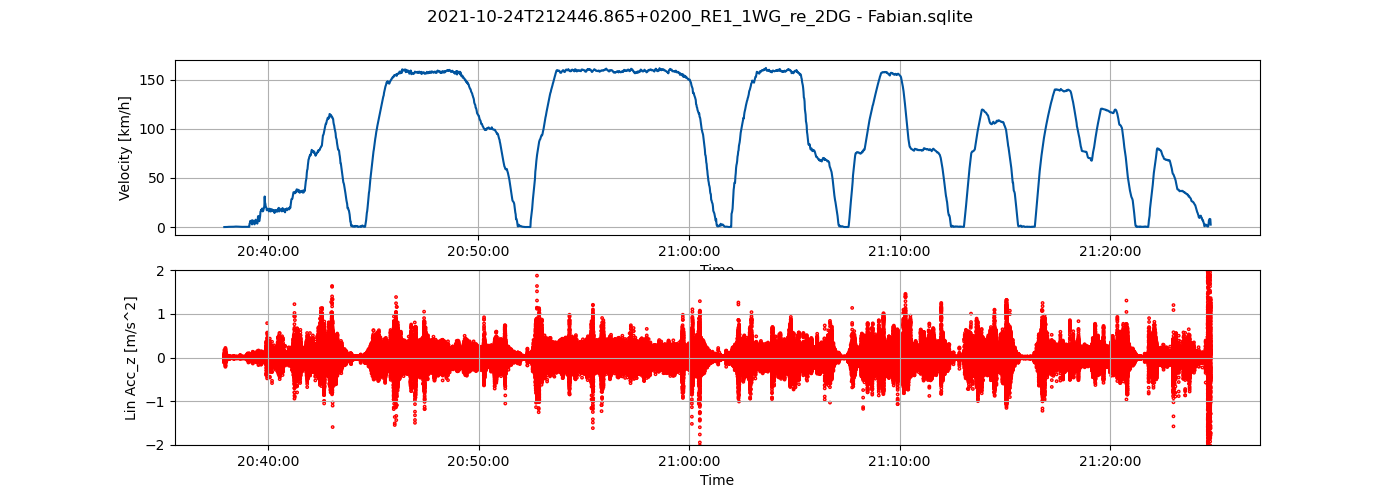

In [17]:
 f = campaign[1] # Individual files can either be accessed over indices or by calling the campaign with the file name campaign("NAME_OF_THE_FILE")

fig, ax = plt.subplots(2, 1, sharex="row", figsize=(14, 5))

# Upper plot showing vehicle speed
ax[0].plot(f.measurements[GPSSeries].time, f.measurements[GPSSeries].speed*3.6)  # Note that individual data series can be accessed using their classes which have to be imported before
ax[0].grid()
ax[0].set_ylabel("Velocity [km/h]")
ax[0].set_xlabel("Time")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Lower plot showing vehicle vertical acceleration
ax[1].scatter(f.measurements[LinearAccelerationSeries].time, f.measurements[LinearAccelerationSeries].lin_acc_z, facecolors='none', edgecolors='r',s=3)
ax[1].grid()
ax[1].set_ylabel("Lin Acc_z [m/s^2]")
ax[1].set_xlabel("Time")
ax[1].set_ylim(-2, 2)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))


plt.suptitle(f.filename)
plt.show()

 ### Calculate Ride Comfort according to EN 12299

In [20]:
proc = ComfortProcessor(campaign, v_thres=10/3.6)
proc.execute()

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
result = campaign.results[ComfortProcessor][campaign[0].filename]
print(result['n_mv'])

1.3643727660163776


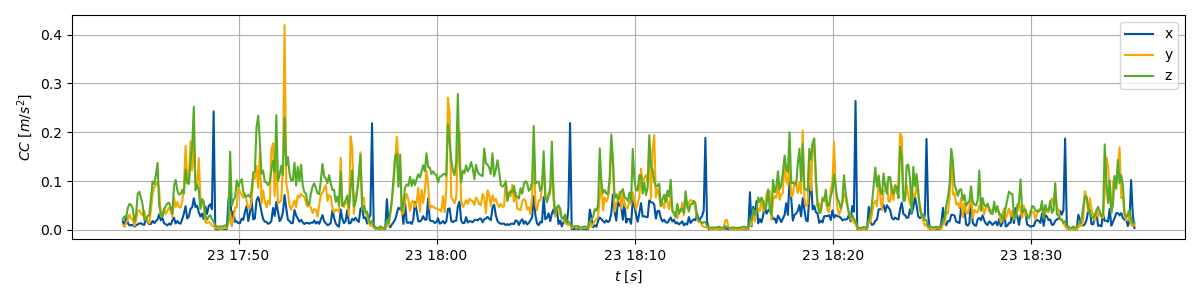

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.plot(result['t'], result['cc_x'], label='x')
ax.plot(result['t'], result['cc_y'], label='y')
ax.plot(result['t'], result['cc_z'], label='z')
ax.grid()

ax.set_xlabel('$t$ [$s$]')
ax.set_ylabel('$CC$ [$m/s^2$]')
ax.legend(loc=1)

plt.tight_layout()
plt.show()

### Get positions of railway track elements like switches, level crossings or signals
The downloaded OSM data contains information about the position of railway switches, level crossings or railway signals.

In [23]:
switches = campaign.osm.get_switches()[:5] # Get the first five switches
switches

[Switch at (6.4881558, 50.8146012),
 Switch at (6.7258688, 50.9209467),
 Switch at (6.1003262, 50.7660038),
 Switch at (6.0944187, 50.7675851),
 Switch at (6.908855, 50.8694203)]

In [24]:
switches[0].__dict__

{'n': <overpy.Node id=21764355 lat=50.8146012 lon=6.4881558>,
 'attributes': {'x': 323054.79238135414,
  'y': 5632215.391414048,
  'allowed_transits': [(4195337122, 21764355, 6482084207),
   (4195337122, 21764355, 4195337123),
   (6482084207, 21764355, 4195337122),
   (4195337123, 21764355, 4195337122)]},
 'tags': {'railway': 'switch',
  'railway:switch': 'default',
  'railway:turnout_side': 'right',
  'ref': '34'},
 'lat': 50.8146012,
 'lon': 6.4881558,
 'id': 21764355,
 'ways': [<overpy.Way id=183652424 nodes=[21764355, 4195337122, 1071425265]>,
  <overpy.Way id=183652427 nodes=[1071425211, 6482084208, 6482084207, 21764355]>,
  <overpy.Way id=445807340 nodes=[4431566396, 4195337124, 21764356, 4195337123, 21764355]>],
 'railway': 'switch',
 'railway:switch': 'default',
 'railway:turnout_side': 'right',
 'ref': '34',
 'allowed_transits': [(4195337122, 21764355, 6482084207),
  (4195337122, 21764355, 4195337123),
  (6482084207, 21764355, 4195337122),
  (4195337123, 21764355, 4195337122)]

In [25]:
print(switches[0].lon, switches[0].lat) # Print e.g. the coordinates of the first switch

6.4881558 50.8146012


In [26]:
signals = campaign.osm.get_signals() # Get railway signals
signals[20].__dict__ # Show the attributes of one exemplary signal

{'n': <overpy.Node id=150638038 lat=50.7680897 lon=6.0927332>,
 'attributes': {'x': 295000.51926725125, 'y': 5628066.302705714},
 'tags': {'railway': 'signal',
  'railway:signal:direction': 'backward',
  'railway:signal:main': 'DE-ESO:ks',
  'railway:signal:main:form': 'light',
  'railway:signal:main:function': 'exit',
  'railway:signal:main:height': 'normal',
  'railway:signal:main:states': 'DE-ESO:hp0;DE-ESO:ks1',
  'railway:signal:main:substitute_signal': 'DE-ESO:dr:zs1',
  'railway:signal:minor': 'DE-ESO:sh1',
  'railway:signal:minor:form': 'light',
  'railway:signal:position': 'left',
  'railway:signal:speed_limit': 'DE-ESO:zs3',
  'railway:signal:speed_limit:form': 'sign',
  'railway:signal:speed_limit:height': 'normal',
  'railway:signal:speed_limit:speed': '40',
  'ref': '04P1'},
 'lat': 50.7680897,
 'lon': 6.0927332,
 'id': 150638038,
 'ways': [<overpy.Way id=15223868 nodes=[150638032, 3510137444, 3510137446, 150638038]>,
  <overpy.Way id=547530845 nodes=[150638038, 419075988,

In [27]:
level_crossings = campaign.osm.get_level_crossings() # Get level crossings
level_crossings[1].__dict__

{'n': <overpy.Node id=32966964 lat=50.7952188 lon=6.1124441>,
 'attributes': {'x': 296508.01275737234, 'y': 5631027.801745732},
 'tags': {'railway': 'level_crossing', 'ref': 'B� 0,010 km'},
 'lat': 50.7952188,
 'lon': 6.1124441,
 'id': 32966964,
 'ways': [<overpy.Way id=17103643 nodes=[775327375, 775327385, 775327382, 424262137, 10077651551, 10077651552, 424262135, 424262132, 4064687370, 32966971, 4064687371, 1786545417, 2248634800, 10077651667, 1786545419, 4064698813, 189768037, 32966965, 4064687372, 10077651668, 798806010, 32966964, 34686421, 321360423, 2248634805, 166509665, 10077651665, 166509676, 2248634813, 32966966, 2248634819, 10077651663, 2248634828, 10077651664, 65187605, 2248634825, 2248634822, 65187608, 2248634816, 2248634809, 10077651662, 10020215448, 1965894488, 32222811, 798806005, 32222810, 798806007, 4458438744]>],
 'railway': 'level_crossing',
 'ref': 'B� 0,010 km'}

### Get railway route information
The OSM data also contains information about that railway lines that use the downloaded tracks

In [28]:
campaign.osm.railway_lines[:10] # Returns the first ten railway lines 

[RB21: Heimbach => D�ren,
 IC 55: K�ln => Leipzig => Dresden,
 RB33: Heinsberg => Aachen,
 ICE 10: Berlin => Bonn => Koblenz,
 RE4: Dortmund => Aachen,
 ICE 79: Bruxelles-Midi => Frankfurt,
 RB24: K�ln => Kall [=> SEV Gerolstein],
 RE22: K�ln => Kall [=> SEV Gerolstein],
 RE29: Aachen => Spa-G�ronst�re,
 ICE 45: K�ln => Mainz]

In [29]:
campaign.osm.get_railway_line("RE1") # Search for a specific railway line

[RE1: Hamm (Westf) => Aachen Hbf, RE1: Aachen Hbf => Hamm (Westf)]

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to the view the attributes of an object (e.g. a switch or railway line), use ".__dict__"
</div>

It is also possible to retrieve the switches that are located on a specific line

In [31]:
 re1_aachen_k�ln = campaign.osm.get_railway_line("RE1")[1]
re1_switches = campaign.osm.get_switches_for_railway_line(re1_aachen_k�ln)
re1_switches[:5]

[Switch at (6.0938667, 50.7678228),
 Switch at (6.0938667, 50.7678228),
 Switch at (6.094951, 50.7674922),
 Switch at (6.094951, 50.7674922),
 Switch at (6.0954098, 50.7673431)]

Plot retrieved switches onto the Map 

In [32]:
from ipyleaflet import Icon, Marker

for sw in re1_switches:
    icon = Icon(icon_url='https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-black.png',
                shadow_url='https://cdnjs.cloudflare.com/ajax/libs/leaflet/0.7.7/images/marker-shadow.png',
                icon_size=[25, 41],
                icon_anchor=[12, 41],
                popup_anchor=[1, -34],
                shadow_size=[41, 41])
    marker = Marker(location=(sw.lat, sw.lon), draggable=False, icon=icon)
    m.add_layer(marker)
            
m

Map(bottom=2998.0, center=[49.43419920856156, -9.640503013506532], controls=(ZoomControl(options=['position', �

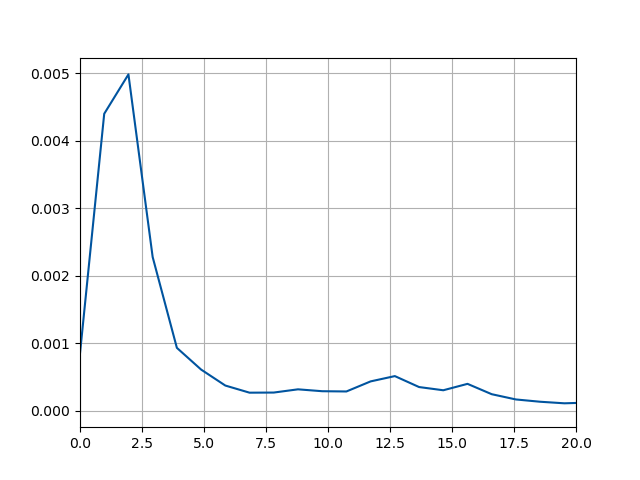

In [33]:
fig, ax = plt.subplots(1, 1)


freq, Pxx = signal.welch(campaign[1].measurements[LinearAccelerationSeries].lin_acc_z, 250, nfft=256)

ax.plot(freq, Pxx)
ax.grid()
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim([0, 20])
plt.show()